# 1. Import and config

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
# overlay.load_model("dpu_testModel_0.elf")

In [2]:
from dnndk import n2cube
import numpy as np
from numpy import float32
import os
import cv2
import matplotlib.pyplot as plt
import time
import DpuCar
from DpuCar import CommonFunction

In [3]:
# KERNEL_CONV="dpuCarModel_0"
# # KERNEL_CONV="miniResNet"

# # 训练用的图像尺寸
# img_size_net = 224
# # 训练的batch大小
# batch_size = 32
# wordlist = ['mask', 'nomask']
# sorts_pathes = ['mask', 'nomask']
# run_path = './'

# 存放转换后的tf数据集的路径
# dataset_tf_path_train = run_path + 'datasetTfTrain.tfrecords'
# dataset_tf_path_test = run_path + 'datasetTfTest.tfrecords'
# CONV_INPUT_NODE = "x_input_Conv2D"
# CONV_OUTPUT_NODE = "y_out_MatMul"

# 2. Loading the dataset

In [4]:
KERNEL_CONV="dpuCarModel_0"
sorts_list = ['mask', 'nomask']
img_size_net = 128
# CONV_INPUT = "x_input"
# # CONV_INPUT = "conv2d_input"
# calib_batch_size = 100
num_photo=0
def load_valid_data(data_path):
    label_cnt = 0
    photo_num = 0
    test_images = []
    test_lables = []
    for sort_path in sorts_list:    
        flower_list = os.listdir(data_path + sort_path)
        for img_name in flower_list:
            photo_num += 1
            img_path = data_path + sort_path + "/" + img_name
            img = cv2.imread(img_path)  
            img_scale = cv2.resize(img,(img_size_net, img_size_net), interpolation = cv2.INTER_CUBIC)
            if not img is None:
                test_images.append(img_scale / 255.)
                test_lables.append(label_cnt)
        label_cnt += 1
    print('There are ',label_cnt,' lables' ,'and',photo_num,' photos')
    return test_images, test_lables, photo_num

# dataset_valid_path = './dataset_valid/'
dataset_valid_path = '../test_data/'
(validSet_images, validSet_lables, num_photo) = load_valid_data(dataset_valid_path)
validSet_images = np.array(validSet_images)
validSet_lables = np.array(validSet_lables)

# def calib_input(iter):
#     images = []
#     for index in range(0, calib_batch_size):
#         images.append(validSet_images[index])

#     return {CONV_INPUT: images}

There are  2  lables and 200  photos


# 3. DPU experiment

## 3.1 Load kernel to DPU

In [5]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
DPU_TASK = n2cube.dpuCreateTask(kernel, mode=2)
# car1 = DpuCar.DpuCar(DPU_TASK, dpu_input_node=, dpu_output_node=， dpu_img_size=)
agent1 = DpuCar.DpuCar(DPU_TASK)

320.0 240.0
30.0


In [7]:
acc = 0
for ii in range(0,num_photo):
    img1_scale = validSet_images[ii]
    pdt = agent1.dpuPredictSoftmax(img1_scale)
    rel = validSet_lables[ii]
    if(pdt==rel):
        acc += 1
print('acc = ',acc/num_photo*100,'%')

acc =  91.0 %


## 3.2 Test experiment with valid_dataset

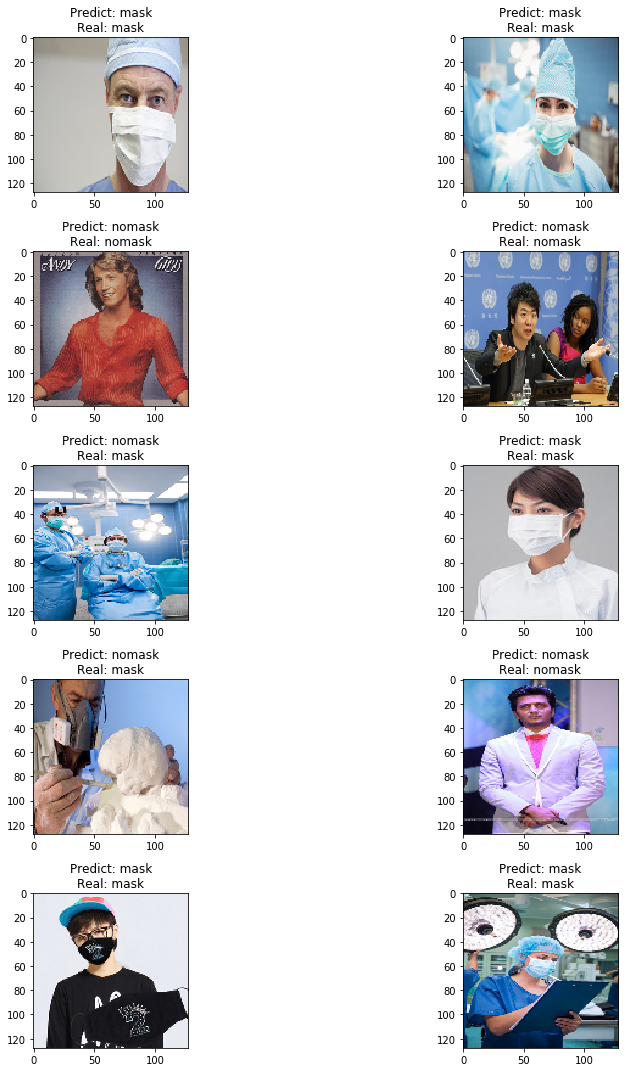

In [7]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l = np.random.randint(0, len(validSet_lables))
        img1_scale = validSet_images[l]
        pdt = agent1.dpuPredictSoftmax(img1_scale)
        img1_scale = np.array(img1_scale, dtype='float32')
        ax[i, j].imshow(cv2.cvtColor(img1_scale, cv2.COLOR_BGR2RGB))
        title = "Predict: " + sorts_list[pdt] + "\n" + "Real: " + sorts_list[validSet_lables[l]]
        ax[i, j].set_title(title)
plt.tight_layout()

# 3.3 Test experiment with USB camera

Please connect the USB camera to the Ultra 96 first.

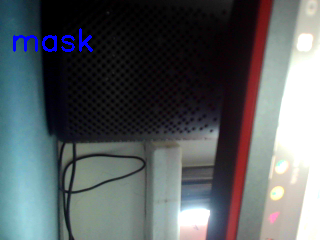

KeyboardInterrupt: 

In [12]:
for i in range(300):
    # clear the output
    CommonFunction.clear_output()
    # read image from camera
    imgMat = agent1.get_image()
    # this image is used for display
    imgShow = cv2.resize(imgMat, (320,240))
    # this image is used for DPU input
    tempImg = cv2.resize(imgMat, (128,128))
    pdt = agent1.dpuPredictSoftmax(tempImg)
    font=cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(imgShow,sorts_list[pdt],(10,50), font, 1,(255,0,0),2)
    # show result
#     print(wordlist[pdt])
    CommonFunction.show_img_jupyter(imgShow)
    time.sleep(0.1)